In [895]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import time

# Metoda Gaussa-Jordana

W pierwszej kolejności zaimplementowano rozwiązywanie układu równań liniowych metodą Gaussa-Jordana. W celu uzyskania jak najlepszej dokładności zastosowano pełny pivoting, skalowanie oraz wymuszanie wartości $0.0$ przy odejmowaniu teoretycznie tych samych wartości. Funkcja *Gauss_Jordan* przyjmuje macierz współczynników $A$ i wektor wyrazów wolnych $B$ i zwraca wektor $X$ będący rozwiązaniem równania $A\cdot X = B$.

In [1002]:
def Gauss_Jordan(A, B):
    
    n = B.shape[0]
    ls = np.concatenate((A, B.reshape((n, 1))), axis=1)
    
    #scalling
    ls = ls/np.max(ls[:, :-1], axis=1, keepdims=True)
    
    permutation = []
    #full pivoting
    for i in range(n):
        p_index = np.unravel_index(np.argmax(np.abs(ls[i:, i:-1])), ls[i:, i:-1].shape)
        p_index = (p_index[0]+i, p_index[1]+i)
        permutation.append(p_index[1])
        ls[[i, p_index[0]]] = ls[[p_index[0], i]]
        ls[:,[i, p_index[1]]] = ls[:,[p_index[1], i]]
        for j in range(i+1, n):
            f = ls[j,i]/ls[i,i]
            ls[j] -= f*ls[i]
            ls[j,i] = 0.0

    
    #back substitution and division
    for i in range(n-1, -1, -1):
        for j in range(i-1, -1, -1):
            f = ls[j,i]/ls[i,i]
            ls[j] -= f*ls[i]
            ls[j, i] = 0.0 
        ls[i, -1]/=ls[i, i]
        
    X = ls[:, -1]
    #coming back to first order
    for i in range(n-1, -1, -1):
        p_index = permutation[i]
        X[[i,p_index]] = X[[p_index, i]]
    
    return X
        

In [1003]:
A_, B_ = random_system(3)

In [1004]:
Gauss_Jordan(A, B)

array([ 1.22079698,  0.52636246, -0.19357429,  0.97052284,  0.67038087])

In [1005]:
np.linalg.solve(A, B)

array([[ 1.22079698],
       [ 0.52636246],
       [-0.19357429],
       [ 0.97052284],
       [ 0.67038087]])

Implementację przetestowano dla trzech losowo wygenerowanych układów równań o kolejno 500, 750 i 1000 niewiadomych i porównano czas działania powyższej implementacji z funkcjami *numpy.linalg.solve*, *numpy.linalg.lstsq* z biblioteki numpy. Sprawdzono również poprawność wyników licząc porównując normę euklidesową wektora zwróconego przez *Gauss_Jordan* i *numpy.linalg.solve*. Wartości liczbowe współczynników i wyrazów wolnych w wygenerowanych układach równań mieściły się w zakresie $[-100, 100)$.

In [904]:
def random_system(n):
    err = 10**(-6)
    A = np.random.uniform(low=-100.0, high=100.0, size=(n, n))
    while np.linalg.det(A)<err:
        A = np.random.uniform(low=-100.0, high=100.0, size=(n, n))
    B = np.random.uniform(low = -100.0, high=100.0, size = (n, 1))
    return (A, B)

def check_time(f, A, B):
    start_time = time.time()
    X = f(A, B)
    end_time = time.time()
    return end_time-start_time, X

def compare(n):
    (A, B) = random_system(n)
    (t1, X1) = check_time(Gauss_Jordan, A, B)
    (t2, X2) = check_time(np.linalg.solve, A, B)
    (t3, X3) = check_time(np.linalg.lstsq, A, B)
    print(f'{n}x{n} sysyem:')
    print(f'Gauss_Jordan time: {t1}')
    print(f'numpy.linalg.solve time: {t2}')
    print(f'numpy.linalg.lstsq time: {t3}')
    print(f'Gauss_Jordan norm: {np.linalg.norm(X1)}')
    print(f'numpy.linalg.solve norm: {np.linalg.norm(X1)}')

In [1016]:
#compare(500)

In [912]:
#compare(750)

In [913]:
#compare(1000)

Normy porównywanych wektorów są sobie równe z dokładnością $10^{-9}$. W poniższej tabeli zaprezentowano czasy działania porównywanych funkcji podane w sekundach.

|       Funkcja      |        500x500       |        750x750       |       1000x1000      |
|:------------------:|:--------------------:|:--------------------:|:--------------------:|
|    Gauss_Jordan    |   2.005581855773926  |   5.355774164199829  |  11.749972581863403  |
| numpy.linalg.solve | 0.007839202880859375 | 0.010325431823730469 | 0.022460460662841797 |
| numpy.linalg.lstsq |  0.11008024215698242 |  0.1452012062072754  |   0.68739914894104   |

Funkcja *Gauss_Jordan* jest około 50 razy wolniejsza niż biblioteczna funkcja *numpy.linalg.solve*. 

Można było przypuszczać, że wolny czas działania jest spowodowany dużą liczbą zamian kolumn i wierszy. Aby to zweryfikować zaimplementowano tę samą funkcję *Gauss_Jordan*, jednak z zastosowaniem częściowego pivotingu w miejscu całkowitego.

In [1068]:
def Gauss_Jordan_partial(A, B):
    
    n = B.shape[0]
    ls = np.concatenate((A, B.reshape((n, 1))), axis=1)
    
    #scalling
    ls = ls/np.max(ls[:, :-1], axis=1, keepdims=True)

    #partial pivoting
    for i in range(n):
        p_index = i + np.argmax(np.abs(ls[i, i:-1]))
        ls[[i, p_index]] = ls[[p_index, i]]
        
        for j in range(i+1, n):
            f = ls[j,i]/ls[i,i]
            ls[j] -= f*ls[i]
            ls[j,i] = 0.0
            
    #back substitution and division
    for i in range(n-1, -1, -1):
        for j in range(i-1, -1, -1):
            f = ls[j,i]/ls[i,i]
            ls[j] -= f*ls[i]
            ls[j, i] = 0.0 
        ls[i, -1]/=ls[i, i]
    
    return ls[:, -1]

In [1069]:
(A, B) = random_system(1000)
(t1, X1) = check_time(Gauss_Jordan, A, B)
(t2, X2) = check_time(Gauss_Jordan_partial, A, B)
(t3, X3) = check_time(np.linalg.solve, A, B)
print(f'Gauss_Jordan time: {t1}')
print(f'Gauss_Jordan_partial time: {t2}')
print(f'numpy.linalg.solve time: {t3}')
print(f'Gauss_Jordan norm: {np.linalg.norm(X1)}')
print(f'Gauss_Jordan_partial norm: {np.linalg.norm(X2)}')
print(f'numpy.linalg.solve norm: {np.linalg.norm(X3)}')

Gauss_Jordan time: 8.34902048110962
Gauss_Jordan_partial time: 6.420051574707031
numpy.linalg.solve time: 0.02563953399658203
Gauss_Jordan norm: 61.40456556514103
Gauss_Jordan_partial norm: 61.404565558881224
numpy.linalg.solve norm: 61.40456556512558


Zaobserwowano pewną zmianę w czasie działania algorytmu, jednak utracono dokładność. Czas działania jest ciągle dużo dłuższy niż dla funkcji z biblioteki numpy. Metoda Gaussa-Jordana ma złożoność $O(n^3)$, tak samo jak rozwiązaywanie układu równań poprzez faktoryzację LU, które wykorzystane jest w implementacji *numpy.linalg.solve*. Różnica w czasie działania, nie wynika więc z teoretycznej złożoności obliczeniowej, a prawdopodobnie z dobrze zopytmalizowanej implementacji funkcji bibliotecznej.

# Faktoryzacja LU

Poniżej zaimplementowano faktoryzację macierzy $A$ na dwie macierze - dolnotrójkątną $L$ i górnotrójkątną $U$. Wykorzystano częściowy pivoting, skalowanie i wymuszanie wartości $0.0$ w miejscu, gdzie teoretycznie powinna się pojawić. Funkcja *LU* przyjmuje macierz $A$ rozmiaru $nxn$ i zwraca jej faktoryzację $L$, $U$ oraz macierz permutacji i skalowania $P$. Macierze te związane są zależnością  $P \cdot A$ = $L \cdot U$. Jeśli zaszłaby potrzeba wyprowadzenia bezpośredniego wzoru na $A$, macierz $P$ można bardzo łatwo odwrócić. Wystarczy, że odwrócimy każdą niezerową wartość w macierzy i tak otrzymaną macierz transponujemy. Transponowanie wynika z ogólnej własności macierzy permutacji, wspomnianej między innymi [tutaj](http://www.math.kent.edu/~reichel/courses/intr.num.comp.1/fall09/lecture9/lecture4.pdf), natomiast odwracanie poszczególnych elementów macierzy ma na celu odpowiednie przeskalowanie kolumn prawej strony równania.

In [1174]:
def LU(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    P = np.identity(n)
    max_w = 1.0/np.max(A, axis=0, keepdims=1)
    A = A*max_w.T
    
    for i in range(n):
       
        p_index = i + np.argmax(np.abs(A[i:, i]))
        A[[i, p_index]] = A[[p_index, i]]
        P[[i, p_index]] = P[[p_index, i]]
        L[[i, p_index]] = L[[p_index, i]]
        
        for j in range(i+1, n):
            f = A[j,i]/A[i,i]
            L[j, i] = f
            A[j] -= f*A[i]
            A[j, i] = 0.0

    P = P * max_w
    L = L + np.identity(n)
            
    return (P, L, A)


In [1207]:
for n in [500, 750, 1000]:
    A = np.random.uniform(-100.0, 100.0, (n, n))
    start_time = time.time()
    (P, L, U) = LU(A)
    end_time = time.time()
    print(f'Marix {n}x{n}:')
    print(f'LU time: {end_time-start_time}')
    start_time = time.time()
    sp.linalg.lu(A)
    end_time = time.time()
    print(f'scipy.linalg.lu time: {end_time-start_time}')
    print(f'LU norm: {np.linalg.norm(L@U)}')
    print(f'PA norm: {np.linalg.norm(P@A)}\n')

Marix 500x500:
LU time: 0.6181092262268066
scipy.linalg.lu time: 0.005213499069213867
LU norm: 290.0139298319441
PA norm: 290.0139298319441

Marix 750x750:
LU time: 1.6188549995422363
scipy.linalg.lu time: 0.018119096755981445
LU norm: 434.3508432034764
PA norm: 434.3508432034765

Marix 1000x1000:
LU time: 3.210310459136963
scipy.linalg.lu time: 0.027558088302612305
LU norm: 578.2759859704258
PA norm: 578.2759859704258



W celu sprawdzenia poprawności implementacji policzono i porównano normy macierzy $P \cdot A$ i $L \cdot U$ dla wymiarów $n \in {500, 750, 1000}$. Porównano również czas działania zaimplementowanej funkcji i funkcji *scipy.linalg.lu*. Jak można było się spodziewać, funkcja bibllioteczna znowu okazała się szybsza.

# Analiza obwodu elektrycznego

Grafy wygenerowano i zapisano przy pomocy biblioteki NetworkX. SEM jest dołączane do sieci w momencie wczytywania sieci z pliku. Jeśli krawędź między podanymi wierchołkami istnieje, SEM jest wpinana szeregowo między te wierzchołki, jeśli nie istnieje, jest wpinana równolegle, a opór przyjmowny na nowej krawędzi wynosi $0$.

In [659]:
def generate_graph(graph_type, n, r):
    
    if graph_type == 'random':
        G = nx.gnp_random_graph(n, 0.5)
        while not nx.is_connected(G):
            G = nx.gnp_random_graph(n, 0.5)
    elif graph_type == '3_regular':
        G = nx.random_regular_graph(3, n)
        while not nx.is_connected(G):
            G = nx.random_regular_graph(3, n)
    elif graph_type == 'bridge':
        G1 = nx.gnp_random_graph(n//2, 0.5)
        while not nx.is_connected(G1):
            G1 = nx.gnp_random_graph(n//2, 0.5)
        G2 = nx.gnp_random_graph(n//2, 0.5)
        while not nx.is_connected(G2):
            G2 = nx.gnp_random_graph(n/2, 0.5)
        mapping = {i:n//2+i for i in range(n//2)}
        nx.relabel_nodes(G2, mapping, copy=False)
        G = nx.compose(G1, G2)
        G.add_edge(0, n//2+1)
    elif graph_type == 'grid':
        Gr = nx.grid_graph(dim=[int(np.sqrt(n)), int(np.sqrt(n))])
        G = nx.Graph()
        for (u, v) in Gr.edges:
            G.add_edge(int(np.sqrt(n))*u[0]+u[1], int(np.sqrt(n))*v[0]+v[1])
    else:
        return 'Not known type'
    
    
    for (i,(u,v,w)) in enumerate(G.edges(data=True)):
        w['sem'] = 0
        w['index'] = i
        if isinstance(r, list):
            w['resistance'] = np.random.uniform(r[0], r[1])
        else:
            w['resistance'] = r
    nx.readwrite.edgelist.write_edgelist(G, f'{graph_type}_n_{n}_r_{r}')
    return G

In [693]:
def read_graph_add_sem(path, u, v, sem):
    G = nx.readwrite.edgelist.read_edgelist(path, nodetype=int)
    pos = nx.spring_layout(G)
    if not G.has_edge(u, v):
        G.add_edge(u, v, resistance = 0.0, index = len(G.edges))
    G[u][v]['sem'] = sem
    return G, pos

Sieć, którą analizowano dana jest grafem $G = (V, E)$.

Do zbudowania potrzebnego układu równań $R\cdot I = E$ podejście opisane między innymi  w pracy [Minimum Cycle Bases and Their Applications$^{[1]}$](https://mediatum.ub.tum.de/doc/1370730/1370730.pdf), a więc wykorzystano:

* wszystkie $|V|$  równań wynikających z I Prawa Kirchhoffa. Dla ustalenia uwagi przyjęto, że prąd płynie od wierzchołka o mniejszym indeksie do wierzchołka o większym indeksie. 
* Równania wynikające z bazy cyklowej grafu $G$. Baza cyklowa jest bazą przestrzeni cyklowej grafu (czyli przestrzeni wektorowej zdefiniowanej nad ciałem $(\mathbb{Z} _2, +_{\mathbb{Z} _2}, \cdot_{\mathbb{Z} _2})$, gdzie każdy wektor reprezentuje cykl). Zgodnie z definicją bazy, z tego podzbioru cykli można wygenerować wszystkie cykle, czyli oczka Kirchhoffa, które możemy zanleźć w grafie $G$. Wynika z tego, że wybierając tylko oczka z bazy cyklowej, uwzględnimy wszystkie opory leżące na krawędziach cyklowych obwodu (a tylko takie potrzebujemy analizować, gdyż wiemy, że na krawędziach niecyklowych będzie $I=0$, więc nie ma potrzeby uwzględniania tamtejszego oporu). Dodatkowo równania zdefiniowane zgodnie z II Prawem Kirchhoffa na podstawie tych cykli będą liniowo niezależne. Baza ta jest znajdowana przy pomocy funkcji z biblioteki NetwokX w czasie $O(n^\gamma)$, gdzie $\gamma \in [2, 3]$ zgodnie z [dokumentacją](https://dl.acm.org/doi/abs/10.1145/363219.363232). 

Równania wynikające z bazy cyklowej nie będą liniowo niezależne z równaniami zdefiniowanymi w punkcie pierwszym. Powołując się jednak na stwierdzenie (Proposition 1) z przywołanego wyżej artykułu $^{[1]}$ wymiar bazy cyklowej, czyli liczba wynikających z niej równań dana jest zależnością: $|B_c| = |E|-|V|+c(G)$, gdzie $c(G)$ to liczba spójnych składowych grafu, która w analizowanych przez nas przykładach zawsze wynosi $1$. Wynika z tego, że określony przez nas układ będzie miał o dokładnie $1$ równanie za dużo, gdyż do jednoznaczengo rozwiązania układu potrzebowalibyśmy dokładnie $|E|$ równań. Do rozwiązania uzykanego układu wykorzystano funkcję np.linalg.solve, która przyjmuje jedynie określony układ równań, dlatego kolejno wykluczano po jednym równaniu i w momencie uzyskania macierzy nieosobliwej rozwiązywano układ równań.

In [771]:
def solve(G):
    R = np.zeros((len(G.edges)+1, len(G.edges)))
    E = np.zeros((len(G.edges)+1, 1))
    
    for u in G.nodes:
        for v in G[u]:
            index = G[u][v]['index']
            #print(u, index)
            #R[int(u)][int(index)] = 1.0 if u < v else -1.0
            R[u][index] = 1.0 if u < v else -1.0

        
    cycle_basis = nx.cycle_basis(G)
    for (c, cycle) in enumerate(cycle_basis):
        sem = 0.0
        for (i, u) in enumerate(cycle):
            
            v = cycle[(i+1) % len(cycle)]
            r = G[u][v]['resistance']
            sem += G[u][v]['sem']
            index = G[u][v]['index']
            
            R[len(G.nodes)+c][index] = r if u < v else -1.0 * r
        E[len(G.nodes)+c] = sem
      
    err = 10**(-6)
    I = np.zeros(len(G.edges))
    for i in range(len(G.edges)+1):
        R_ = np.delete(R, i, 0)
        if abs(np.linalg.det(R_))>err:
            E_ = np.delete(E, i, 0)
            return np.linalg.solve(R_, E_).squeeze()
        
    print(R)
    print(E)
    return 'error'

Poprawność otrzymanego wyniku sprawdzono na podstawie I Prawa Kirchhoffa dla każdego węzła oraz dla każdego cyklu bazowego na podstawie II Prawa Kirchhoffa.

In [606]:
def check_kirchhoff_laws(G, I):
    err = 10**(-6)
    
    #check I Kirchhoff Law
    for u in G.nodes:
        curr = 0.0
        for v in G[u]:
            c =  I[G[u][v]['index']] if u<v else -1.0*I[G[u][v]['index']]
            curr += c
        #print(curr)
        if curr > err:
            return 'I Kirchhoff Law Error'
        
    cycle_basis = nx.cycle_basis(G)
    for (c, cycle) in enumerate(cycle_basis):
        sem = 0.0
        r_curr = 0.0
        for (i, u) in enumerate(cycle):
            
            v = cycle[(i+1) % len(cycle)]
            r = G[u][v]['resistance']
            sem += G[u][v]['sem']
            c =  I[G[u][v]['index']] if u<v else -1.0*I[G[u][v]['index']]
            r_curr += c*G[u][v]['resistance']
            
        if abs(sem-r_curr)>err:
            return 'II Kirchhoff Law Error'
        
    return 'Solution works'

In [780]:
def draw_graph(G, I, pos, title):
    G_D = G.to_directed()

    for (u, v) in G.edges:
        if I[G[u][v]['index']]>0.0:
            u, v = max(u, v), min(u, v)
        else:
            u, v = min(u, v), max(u, v)
            
        G_D.remove_edge(u, v)
        G_D[v][u]['I'] = I[G[u][v]['index']]
        
    colors = [-1*abs(int(1000*G_D[u][v]['I'])) for u,v in G_D.edges]
    width = [1 if G_D[u][v]['sem']==0.0 else 4 for u, v in G_D.edges]
    #r = {G_D[u][v]['resistance'] for u, v in G_D.edges}
    plt.figure(1,figsize=(10,10))
    plt.suptitle(title)
    #nx.draw_networkx_edge_labels(G_D, pos)
    nx.draw(G_D, pos, edge_color=colors, node_color = 'black', node_size = 20, width=width)
    plt.show()


Poniżej przedstawiono wizualizację prądu przepływającego przez przykładowe sieci o liczbach wierzchołków $|V| \in [15, 100]$. Strzałki wskazują kierunek przepływu prądu, kolor odzwierciedla wartość natężenia (ciemniejszy kolor - większe natężenie). Krawędź z SEM jest grubsza od innych krawędzi). Wszystkie rozwiązania przetestowano funkcją *check_kirchhoff_laws*.

In [555]:
#generate_graph("random", 20, [0, 10])

Solution works


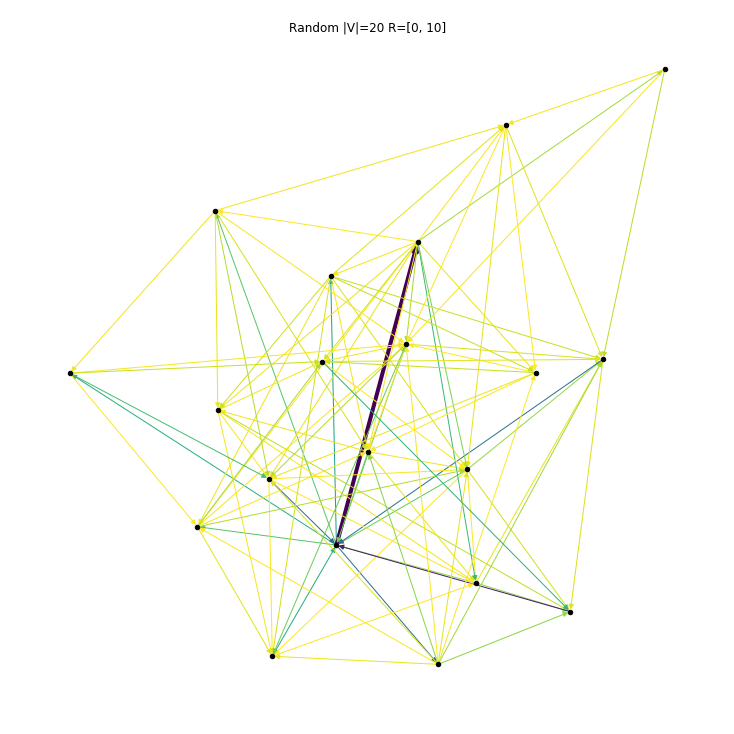

In [733]:
Random1, pos = read_graph_add_sem('./random_n_20_r_[0, 10]', u=1, v=19, sem=10)
I = solve(Random1)
print(check_kirchhoff_laws(Random1, I))
draw_graph(Random1, I, pos, 'Random |V|=20 R=[0, 10]')

Tak, jak można było przewidzieć, większe natężenie (fioletowe i zielone krawędzie) prądu jest notowane wokół wierzchołków, między którymi wpięto SEM.

In [762]:
#generate_graph("random", 30, 10)

Solution works


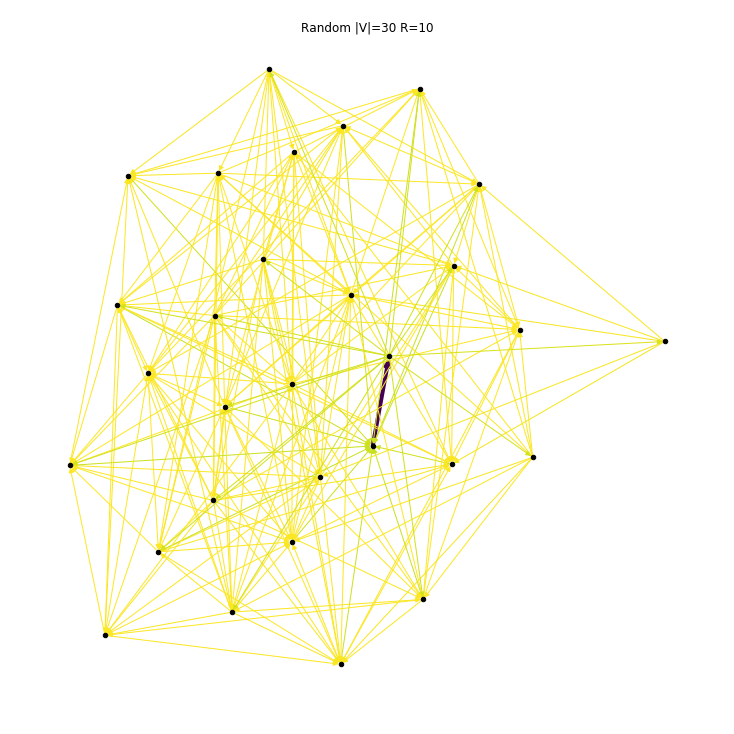

In [781]:
Random2, pos = read_graph_add_sem('./random_n_30_r_10', u=1, v=19, sem=10)
I = solve(Random2)
print(check_kirchhoff_laws(Random2, I))
draw_graph(Random2, I, pos, 'Random |V|=30 R=10')

Dla krawędzi o tym samym oporze widać, że przepływ prądu jest bardziej równomierny.

In [626]:
#generate_graph("bridge", 50, [0,10])

Solution works


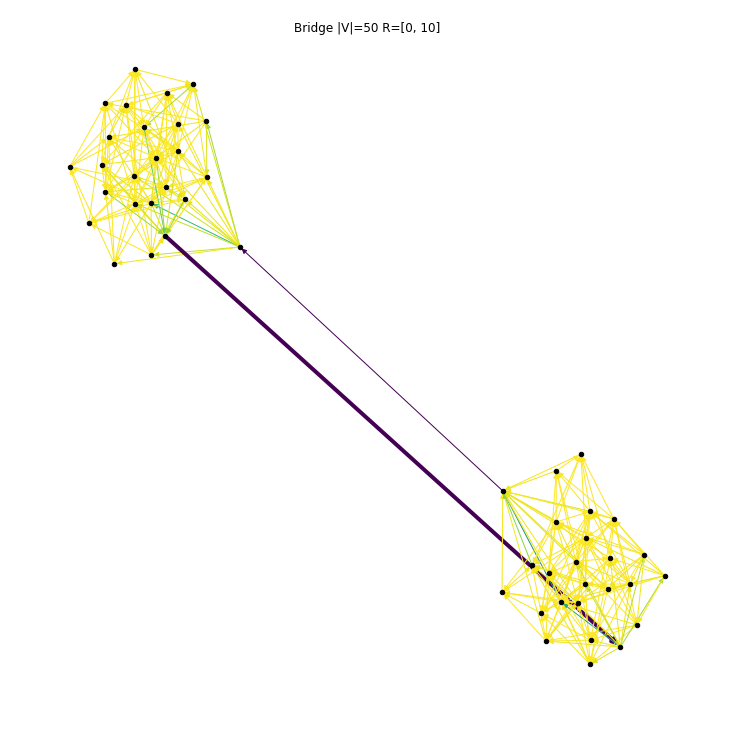

In [785]:
Bridge1, pos = read_graph_add_sem('./bridge_n_50_r_[0, 10]', u=1, v=49, sem=10)
I = solve(Bridge1)
print(check_kirchhoff_laws(Bridge1, I))
draw_graph(Bridge1, I, pos, 'Bridge |V|=50 R=[0, 10]')

Jeżeli dla grafu z mostem przyłożymy SEM między jego dwoma częściami, największy prąd popłynie przez most.

In [634]:
#generate_graph("bridge", 80, [0,10])

Solution works


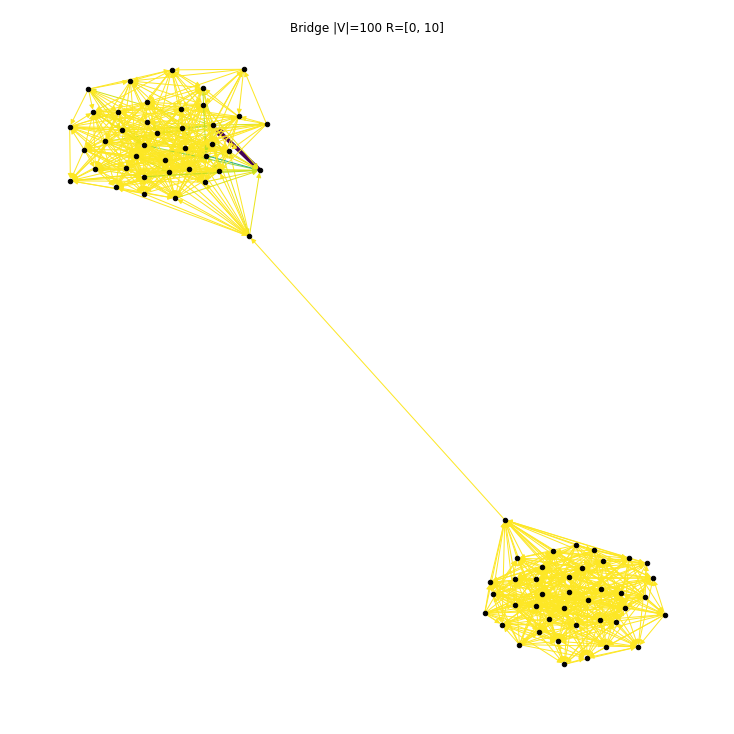

In [636]:
Bridge2, pos = read_graph_add_sem('./bridge_n_80_r_[0, 10]', u=1, v=2, sem=10)
I = solve(Bridge2)
print(check_kirchhoff_laws(Bridge2, I))
draw_graph(Bridge2, I, pos, 'Bridge |V|=80 R=[0, 10]')

Sytuacja wygląda inaczej, jeżeli SEM przyłożymy między wierzchołkami jednej z części. W takiej sytuacji prąd nie popłynie do drugiej z nich.

In [637]:
#generate_graph("3_regular", 100, 10)

Solution works


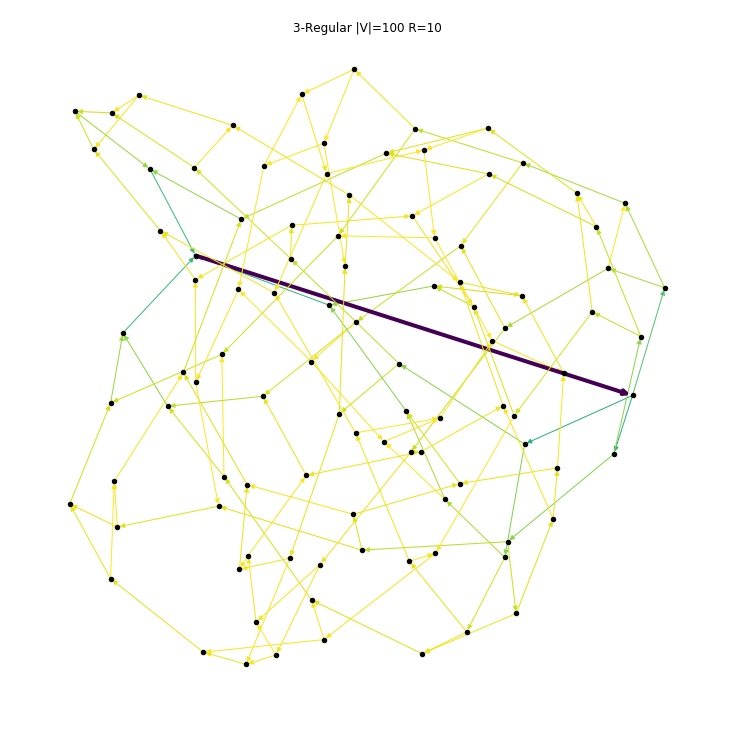

In [782]:
Regular1, pos = read_graph_add_sem('./3_regular_n_100_r_10', u=1, v=49, sem=10)
I = solve(Regular1)
print(check_kirchhoff_laws(Regular1, I))
draw_graph(Regular1, I, pos, '3-Regular |V|=100 R=10')

In [705]:
#generate_graph("grid", 25, 10)

Solution works


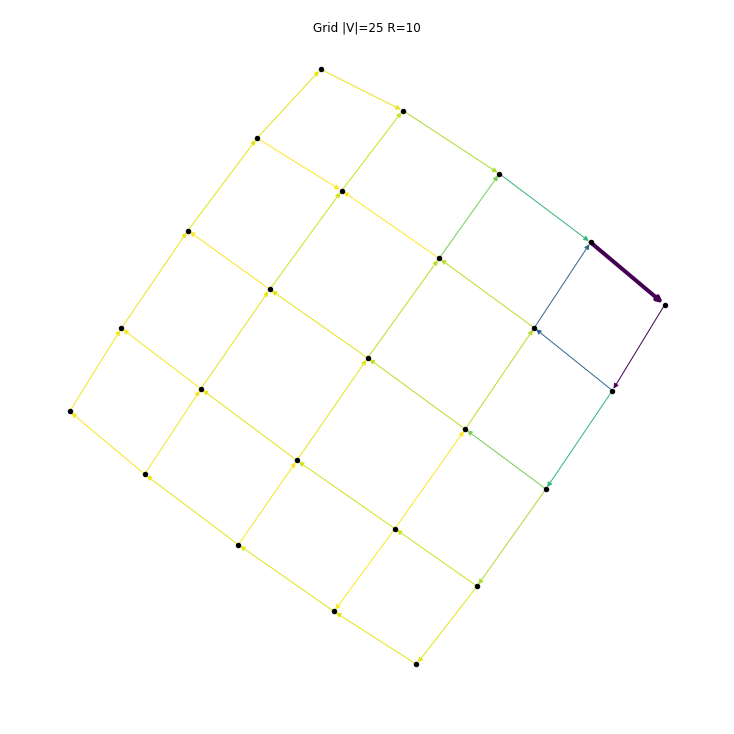

In [729]:
Grid1, pos = read_graph_add_sem('./grid_n_25_r_10', 0, 1, 10)
I = solve(Grid1)
print(check_kirchhoff_laws(Grid1, I))
draw_graph(Grid1, I, pos, 'Grid |V|=25 R=10')

In [711]:
#generate_graph("grid", 64, [0, 10])

Solution works


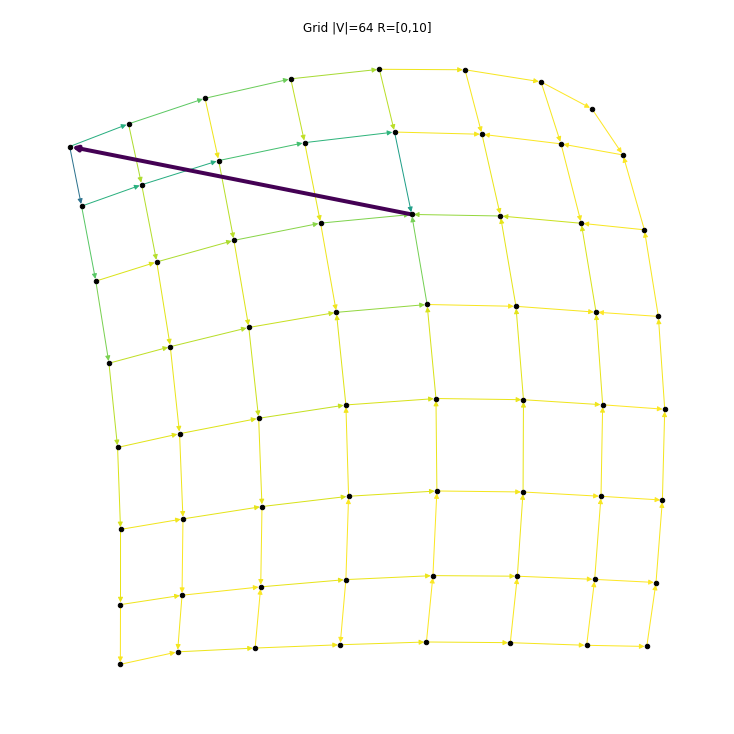

In [728]:
Grid2, pos = read_graph_add_sem('./grid_n_64_r_[0, 10]', 0, 20, 10)
I = solve(Grid2)
print(check_kirchhoff_laws(Grid2, I))
draw_graph(Grid2, I, pos, 'Grid |V|=64 R=[0,10]')